In [1]:
try:
    import torch
except ModuleNotFoundError:
    !pip install torch==1.13.0+cu117 torchvision==0.14.0+cu117 torchaudio==0.13.0 --extra-index-url https://download.pytorch.org/whl/cu117


# Run this the following code only when using Colab
if "google.colab" in str(get_ipython()):
    import os
    if not os.path.isdir('aimed'):
        import subprocess
        
        # Clone SCC
        subprocess.run(["git", "clone", "https://github.com/OSU-MR/aimed.git"]) 
        # Change directory
        os.chdir('aimed')
        # Install requirements
        !pip install keras==2.9.0 lpips==0.1.4 matplotlib==3.5.2 nibabel==4.0.1 numba==0.58.1 numpy==1.26.2 opencv-python==4.6.0.66 tensorflow==2.9.1 dists-pytorch==0.1 torchgeometry==0.1.2 torchmetrics==0.10.0 torchsummary==1.5.1 tqdm==4.64.0 voxelmorph==0.2 batchgenerators==0.24


else:
    #clone LDC repository if not already cloned
    print('Not using colab, make sure you have cloned AiMED repo')
    try:
        from LDC.modelB4 import LDC
    except ModuleNotFoundError:
        try:
            !git clone https://github.com/xavysp/LDC.git
        except:
            subprocess.run(["git", "clone", "https://github.com/xavysp/LDC.git"])

Not using colab, make sure you have cloned AiMED repo


# This demo shows how to load pretrained weights for AiM-ED and pass MRI images through the network

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from batchgenerators.utilities.file_and_folder_operations import *

####
from scripts.helpful_functions import *
from scripts.nn_modules import *
from scripts.variables import *
from scripts.loss import *
from scripts.data_loader import load_data
from scripts.utils import *
from scripts.generator import create_generators_val



## For custom data, normalizing for the data is needed.
## Following function can be used to do that.

In [3]:
def normalize_energy(arr , percentage = 90):
    #assert if arr is not complex
    assert np.iscomplexobj(arr) == True, 'input array has to be complex, \n if you do not have the phase, try creating zero phase by creating a complex array \n with real part and imaginary part equal to the magnitude value'
    # input complex array shape: (repeating, height, width), example: (15, 256, 192)
    arr_angle = np.angle(arr) #get the phase
    arr_m     = np.abs(arr)   #get the magnitude
    
    arr_m_shape = arr_m.shape
    arr_percentile_all = arr_m.copy() 
    
    percentile_factor = np.percentile(arr_percentile_all,percentage)
    #print('percentile',percentile)

    arr_m = arr_m.reshape(arr_m_shape[0],-1)

    for i in range(arr_m_shape[0]):
        #normalize each repeating by the same number
        arr_m[i] = np.divide(arr_m[i], percentile_factor)
    
    #put phase back
    arr_normalized = arr_m.reshape(arr_m_shape)*np.exp(1j*arr_angle)
        
    return arr_normalized

## Load Data

<span style="color: red;">Important:</span><br><br>If you are using custom data, perform the registration before padding the data in k-space for making it square pixel. Padding after registration can alter the noise characteristics, making it non-Gaussian.<br><br>The dataset '0.55T_low SNR_data' serves as an example. Padding it to square pixels after registration can compromise the quality of the result.

In [4]:
class Dataset_Args:
    def __init__(self):
        self.dataset_shape = "256by192"  # Initial shape of the dataset, it will be cropped to 192x192 for fitting the network
        self.view_list = ['SAX'] # We are only loading SAX images here
        self.suffix = '_c'  #_c for instensity corrected images. Please check https://arxiv.org/abs/2312.00936 for more information

from predefined_dataset_idx import dataset_idx_demo

# 0 for digital phantom, 1 for healthy subject, 2 for patient, 4 for 0.55T low SNR data
#check predefined_dataset_idx.dataset_idx_demo for more information
dataset_names = {'digital_phantom': 0, 'healthy_subject': 1, 'patient': 2, '0.55T_low SNR_data': 3}

dataset_type = dataset_names['digital_phantom']
# dataset_type = dataset_names['healthy_subject']
# dataset_type = dataset_names['patient']
# dataset_type = dataset_names['0.55T_low SNR_data'] 
#load data idx
dataset_args = Dataset_Args()
dataset_args.patients_train = None #we don't need this for evaluation
dataset_args.patients_val = None #we don't need this for evaluation
dataset_args.patients_test = dataset_idx_demo[dataset_type]['test']
#load data
_, _, data_test, vol_shape = load_data(dataset_args)

Base path: /home/Xuan/Registration/aimed/
Loading /home/Xuan/Registration/aimed/niidata_c/patient10000_SAX.nii.gz
testing, 1 patients, SAX shape: (1, 29, 2, 2, 192, 192)
Testing volume shape: [192, 192]


## Check the loaded data

Data Shape of the SAX view: (1, 29, 2, 2, 192, 192)


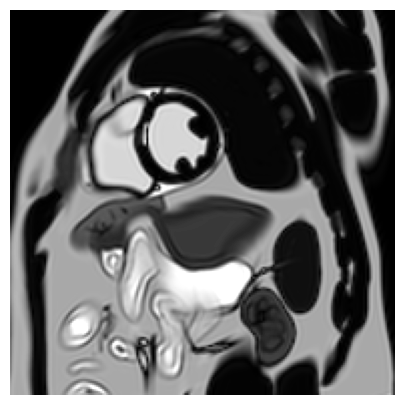

In [5]:
#check the data shape
print('Data Shape of the SAX view:', data_test['SAX'].shape)
#dimension information (slice, repeat, phase_correction_or_not, complex channels ,height, width)

#plot one image
slice_idx = dataset_idx_demo[dataset_type]['demo_slice_idx']
repeat_idx = 14
example_noisy_image = data_test['SAX'][slice_idx, repeat_idx, 0, 0,...] + 1j*data_test['SAX'][slice_idx, repeat_idx, 0, 1,...]
#plot magnitude and phase of the complex image in a row
plt.figure(figsize=(5,5))
plt.imshow(np.abs(example_noisy_image), cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.show()


## Add noise to the data

In [6]:
#Change the following number to change the noisy level
if dataset_type != 3:
    Target_SNR = 6
else:
    Target_SNR = 1000 #large number for not adding noise
dataset_test, _, dataset_test_with_noise, _ = add_noise_of_certain_SNR(data_test, None, SNR = Target_SNR,to_print = True)

Input Data Shape1 : (1, 29, 2, 2, 192, 192)
input SNR: 6   avg standard deviation added (tr,ts): 0.1593856898480174 0.0


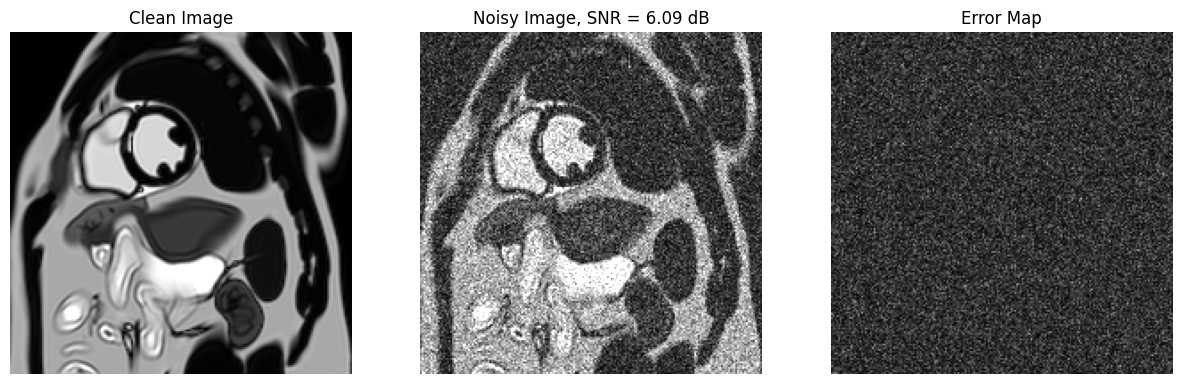

In [7]:

slice_idx = dataset_idx_demo[dataset_type]['demo_slice_idx']
repeat_idx = 14 #index for repeating/average dimension
example_clean_image = dataset_test[slice_idx, repeat_idx, 0, 0,...] + 1j*dataset_test[slice_idx, repeat_idx, 0, 1,...]
example_noisy_image = dataset_test_with_noise[slice_idx, repeat_idx, 0, 0,...] + 1j*dataset_test_with_noise[slice_idx, repeat_idx, 0, 1,...]
#plot magnitude and phase of the complex image in a row
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.imshow(np.abs(example_clean_image), cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.title('Clean Image')
plt.subplot(1, 3, 2)
plt.imshow(np.abs(example_noisy_image), cmap='gray', vmin=0, vmax=1)
plt.axis('off')
actual_SNR = round(SNR(example_clean_image,example_noisy_image),2)
plt.title('Noisy Image, SNR = ' + str(actual_SNR) + ' dB')
plt.subplot(1, 3, 3)
plt.imshow(np.abs(example_noisy_image - example_clean_image), cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.title('Error Map')
plt.show()

## Define model and data generator

In [8]:
model_name = 'AiM_model'
device_number = 0
interpolation_model = 'bicubic'
int_steps = 0

if dataset_type == 0:
    pre_trained_weight_path = './pre_trained_weights/digital_phantom/0.08_0.05_AiM_model_loss_LDC_bicubic_28_2_2500/20240321085213.weights'
else:
    pre_trained_weight_path = './pre_trained_weights/healthy_subject/0.08_0.05_AiM_model_loss_LDC_bicubic_28_3_2500/20240220202011.weights'

model = create_model(model_name, device_number, mode2train= interpolation_model , int_steps = int_steps, pre_trained_weight_path = pre_trained_weight_path).to(device[device_number])

selected_target = 14
prefix_val = 'test_data' #prefix for saving the clean and noisy data for further comparison with other methods
generator_test = create_generators_val(model_name, dataset_test, dataset_test_with_noise, selected_target= selected_target, prefix_val = '_'+str(Target_SNR)+'dB_'+prefix_val,
                                                  brightness_augmentation = False, data_shift = False, change_noise = False, 
                                                  data_start = 7, data_end = 22)
           

/home/Xuan/.conda/envs/aimed/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/Xuan/Registration/aimed/scripts/nn_modules.py:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by th

creating a generator for AiM(average VXM) model
data loaded, path:
val__6dB_test_data_self.dataset_temp.npy
val__6dB_test_data_self.clear_data_temp.npy


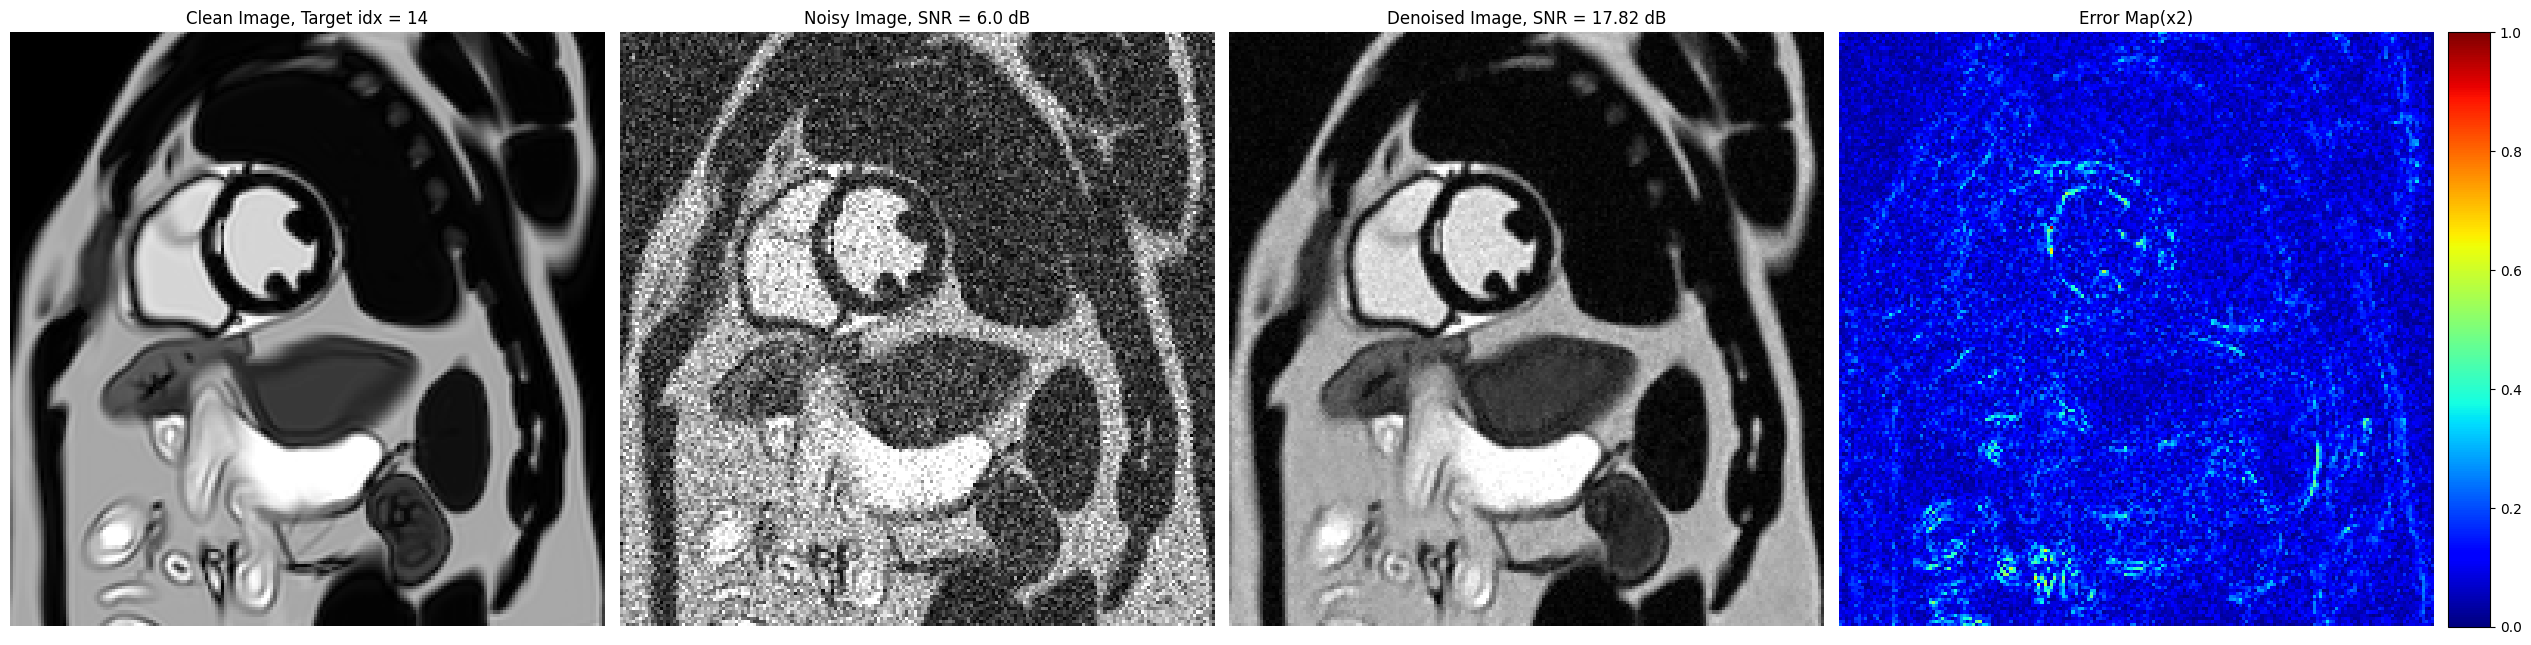

In [9]:
model.eval()
for inputs, y_true in generator_test:
    inputs = [torch.from_numpy(d).to(device[device_number]).float() for d in inputs]
    y_true = [torch.from_numpy(d).to(device[device_number]).float() for d in y_true]
    y_pred = model(*inputs)  

    ref_complex = (y_true[0][0,0,...]+1j*y_true[0][0,1,...]).cpu().detach().numpy()
    noisy_target_complex = (inputs[0][0,0,...]+1j*inputs[0][0,1,...]).cpu().detach().numpy()
    result_complex = (y_pred[0][0,0,...]+1j*y_pred[0][0,1,...]).cpu().detach().numpy()
    diff_complex = ref_complex - result_complex

    if dataset_type != 3:
        SNR_for_test = round(SNR(ref_complex,result_complex),2)
        SNR_for_noisy_image = round(SNR(ref_complex,noisy_target_complex),2)

    fig = plt.figure(figsize=(32, 8))
    grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.15, share_all=True, cbar_location="right", cbar_mode="single", cbar_size="7%", cbar_pad=0.15)

    # True image
    ax = grid[0];im = ax.imshow(np.abs(ref_complex), cmap='gray', vmin=0, vmax=1);ax.axis('off')

    #noisy image
    ax = grid[1];ax.imshow(np.abs(noisy_target_complex), cmap='gray', vmin=0, vmax=1);ax.axis('off')

    # Result image
    ax = grid[2];ax.imshow(np.abs(result_complex), cmap='gray', vmin=0, vmax=1);ax.axis('off')

    # Difference image
    ax = grid[3];im = ax.imshow(np.abs(diff_complex)*2, cmap='jet', vmin=0, vmax=1);ax.axis('off')

    # Add colorbar for the last image
    grid.cbar_axes[0].colorbar(im)

    # Set titles
    grid[0].set_title('Clean Image, Target idx = ' + str(selected_target))

    if dataset_type != 3:
        grid[1].set_title('Noisy Image, SNR = ' + str(SNR_for_noisy_image) + ' dB')
        grid[2].set_title('Denoised Image, SNR = ' + str(SNR_for_test) + ' dB')
    else:
        grid[1].set_title('Noisy Image, No Noise Added')
        grid[2].set_title('Denoised Image')

    grid[3].set_title('Error Map(x2)')

    plt.show()

## Find the best result according to the enery of the deformation map

/home/Xuan/Registration/aimed/scripts/nn_modules.py:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.vxm_block.load_state_dict(torch.load(pre_trained_weight_path, map

data delta: 15
creating a generator for AiM(average VXM) model
data loaded, path:
val__6dB_test_data_self.dataset_temp.npy
val__6dB_test_data_self.clear_data_temp.npy
Deformation energy for target idx: 0 34.53699371218681
Deformation energy for target idx: 1 23.167414635419846
Deformation energy for target idx: 2 28.984443187713623
Deformation energy for target idx: 3 53.518294245004654
Deformation energy for target idx: 4 26.650805324316025
Deformation energy for target idx: 5 58.211546674370766
Deformation energy for target idx: 6 35.33520218729973
Deformation energy for target idx: 7 55.08735208213329
Deformation energy for target idx: 8 22.810349628329277
Deformation energy for target idx: 9 38.94158361852169
Deformation energy for target idx: 10 23.82689878344536
Deformation energy for target idx: 11 22.22896982729435
Deformation energy for target idx: 12 34.8884759247303
Deformation energy for target idx: 13 78.87298661470413
Deformation energy for target idx: 14 60.4537093639373

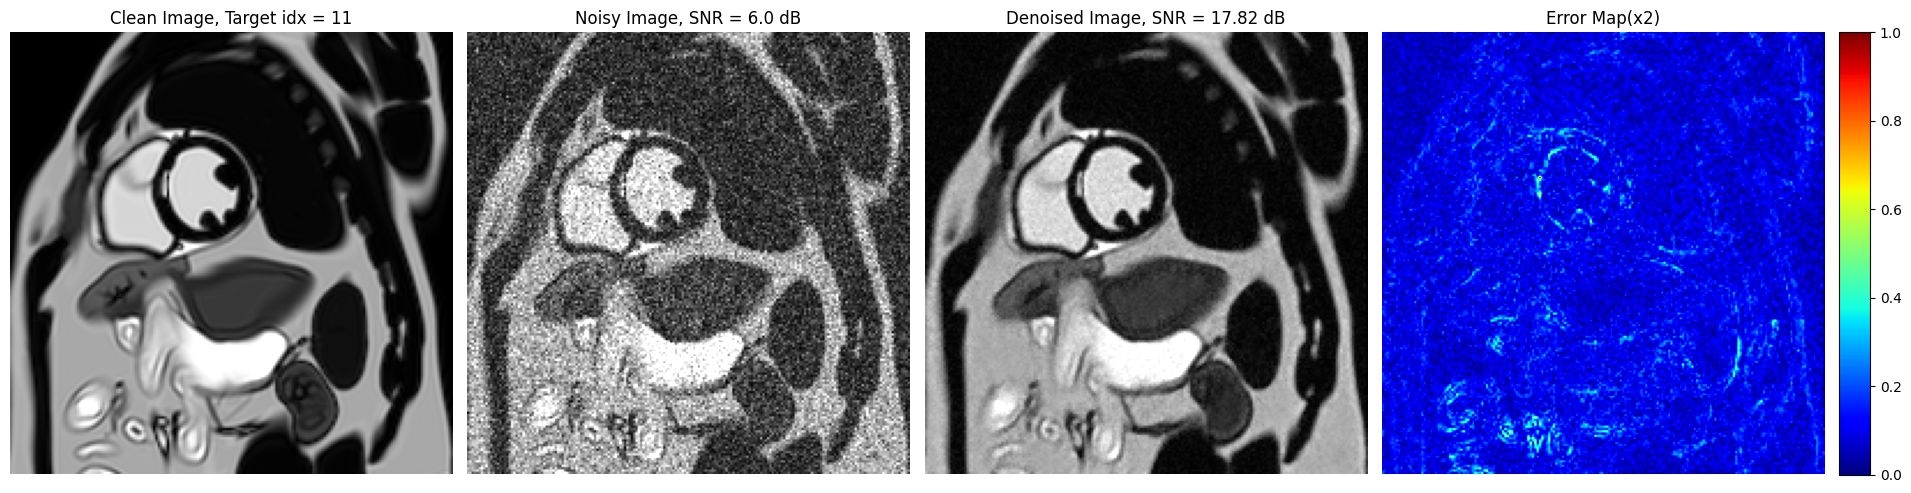

In [10]:
#clean the dataset cache
#this data is the same as the original clean data
try:
    os.remove('val__'+str(Target_SNR)+'dB_'+prefix_val+'_self.dataset_temp.npy')  
    #this data is the noisy data use this for further comparison with other methods without changing the noise realization
    os.remove('val__'+str(Target_SNR)+'dB_'+prefix_val+'_self.clear_data_temp.npy')
except:
    pass

# we can also find the best target image according to the energy of the deformation map
model_name = 'AiM_model'
device_number = 0
interpolation_model = 'bicubic'
int_steps = 0

if dataset_type == 0:
    pre_trained_weight_path = './pre_trained_weights/digital_phantom/0.08_0.05_AiM_model_loss_LDC_bicubic_28_2_2500/20240321085213.weights'
else:
    pre_trained_weight_path = './pre_trained_weights/healthy_subject/0.08_0.05_AiM_model_loss_LDC_bicubic_28_3_2500/20240220202011.weights'

model = create_model(model_name, device_number, mode2train= interpolation_model , int_steps = int_steps, pre_trained_weight_path = pre_trained_weight_path).to(device[device_number])
#orginal data has 29 images, following index is doing data[data_start:data_end] for using only 15 images
#you can change the data_start and data_end to use different number of source images
data_start = 7
data_end = 22
print('data delta:', data_end - data_start )
selected_target = list(range(data_end - data_start)) #go through all the targets to find the best one according to the energy of the deformation map, we have 15 repeats here
prefix_val = 'test_data' #prefix for saving the clean and noisy data for further comparison with other methods
generator_test = create_generators_val(model_name, dataset_test, dataset_test_with_noise, selected_target= selected_target, prefix_val = '_'+str(Target_SNR)+'dB_'+prefix_val,
                                                  brightness_augmentation = False, data_shift = False, change_noise = False, 
                                                  data_start = data_start, data_end = data_end)

deformation_energy_min = np.inf
deformation_energy_min_idx = None

model.eval()
j = 0
for inputs, y_true in generator_test:
    inputs = [torch.from_numpy(d).to(device[device_number]).float() for d in inputs]
    y_true = [torch.from_numpy(d).to(device[device_number]).float() for d in y_true]
    y_pred = model(*inputs)  

    #calculate the energy of the deformation map they are y_pred[1] ~ y_pred[-1] totally 14 deformation maps
    current_deformation_energy = 0
    for i in range(1, len(y_pred)):
        current_deformation_energy += np.mean(np.abs(y_pred[i].cpu().detach().numpy())**2)
    print('Deformation energy for target idx:', j, current_deformation_energy)
    if current_deformation_energy < deformation_energy_min:
        deformation_energy_min = current_deformation_energy
        deformation_energy_min_idx = j

        ref_complex = (y_true[0][0,0,...]+1j*y_true[0][0,1,...]).cpu().detach().numpy()
        noisy_target_complex = (inputs[0][0,0,...]+1j*inputs[0][0,1,...]).cpu().detach().numpy()
        result_complex = (y_pred[0][0,0,...]+1j*y_pred[0][0,1,...]).cpu().detach().numpy()
        diff_complex = ref_complex - result_complex

    j += 1


if dataset_type != 3:
    SNR_for_test = round(SNR(ref_complex,result_complex),2)
    SNR_for_noisy_image = round(SNR(ref_complex,noisy_target_complex),2)

fig = plt.figure(figsize=(24, 6))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.15, share_all=True, cbar_location="right", cbar_mode="single", cbar_size="7%", cbar_pad=0.15)
# True image
ax = grid[0];im = ax.imshow(np.abs(ref_complex), cmap='gray', vmin=0, vmax=1);ax.axis('off')
#noisy image
ax = grid[1];ax.imshow(np.abs(noisy_target_complex), cmap='gray', vmin=0, vmax=1);ax.axis('off')
# Result image
ax = grid[2];ax.imshow(np.abs(result_complex), cmap='gray', vmin=0, vmax=1);ax.axis('off')
# Difference image
ax = grid[3];im = ax.imshow(np.abs(diff_complex)*2, cmap='jet', vmin=0, vmax=1);ax.axis('off')
# Add colorbar for the last image
grid.cbar_axes[0].colorbar(im)
# Set titles
grid[0].set_title('Clean Image, Target idx = ' + str(deformation_energy_min_idx))
if dataset_type != 3:
    grid[1].set_title('Noisy Image, SNR = ' + str(SNR_for_noisy_image) + ' dB')
    grid[2].set_title('Denoised Image, SNR = ' + str(SNR_for_test) + ' dB')
else:
    grid[1].set_title('Noisy Image, No Noise Added')
    grid[2].set_title('Denoised Image')
grid[3].set_title('Error Map(x2)')
plt.show()


## Delete the clean and the noisy data
## Commentting the following cell for further comparison

In [11]:
#delete temporary files if you don't need to keep the noisy the same for further comparison between different methods
#comment the following line if you want to keep the noisy data
#delete_temp_files  'val__'+str(Target_SNR)+'dB_'+prefix_val+'_self.dataset_temp.npy'

#this data is the same as the original clean data
os.remove('val__'+str(Target_SNR)+'dB_'+prefix_val+'_self.dataset_temp.npy')  
#this data is the noisy data use this for further comparison with other methods without changing the noise realization
os.remove('val__'+str(Target_SNR)+'dB_'+prefix_val+'_self.clear_data_temp.npy') 